# 필요 모듈 임포트

In [153]:
import torch
print(torch.__version__)

2.6.0+cu124


In [154]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import sentencepiece as spm

import math
import os
import re
import urllib.request
import zipfile
import numpy as np
import matplotlib.pyplot as plt

# 챗봇 데이터 다운로드 및 EDA

In [155]:
!mkdir -p /content/transformer_chatbot/data && cd /content/transformer_chatbot/data && wget 'https://github.com/songys/Chatbot_data/raw/master/ChatbotData.csv'

--2025-08-18 08:42:43--  https://github.com/songys/Chatbot_data/raw/master/ChatbotData.csv
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/songys/Chatbot_data/master/ChatbotData.csv [following]
--2025-08-18 08:42:43--  https://raw.githubusercontent.com/songys/Chatbot_data/master/ChatbotData.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 889842 (869K) [text/plain]
Saving to: ‘ChatbotData.csv.2’

ChatbotData.csv.2   100%[===================>] 868.99K  --.-KB/s    in 0.05s   

2025-08-18 08:42:43 (18.2 MB/s) - ‘ChatbotData.csv.2’ saved [889842/889842]



In [156]:
import pandas as pd

df = pd.read_csv('/content/transformer_chatbot/data/ChatbotData.csv')

In [157]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11823 entries, 0 to 11822
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Q       11823 non-null  object
 1   A       11823 non-null  object
 2   label   11823 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 277.2+ KB


q,a,label 로 이루어져있다

In [158]:
df.head()

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


In [159]:
df['label'].value_counts()

,count
label,
0,5290
1,3570
2,2963


In [160]:
df['Q'].str.len()

,Q
0,6
1,11
2,12
3,15
4,7
...,...
11818,14
11819,14
11820,11
11821,23


In [161]:
df['A'].str.len()

,A
0,10
1,9
2,11
3,11
4,10
...,...
11818,18
11819,13
11820,6
11821,24


In [162]:
df['q_len'] = df['Q'].str.len()
df['a_len'] = df['A'].str.len()

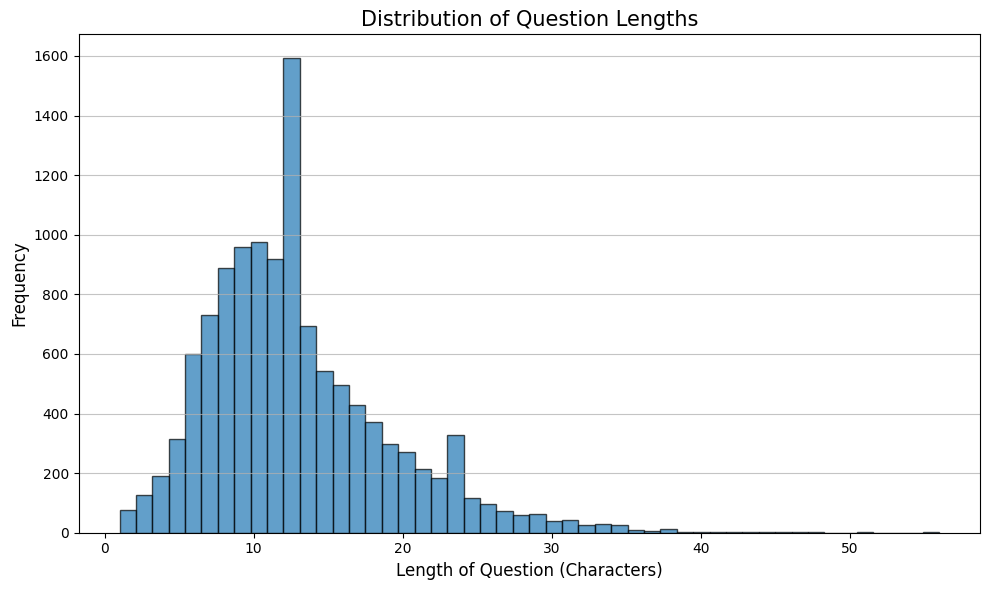

In [163]:
# 질문 길이 분포 히스토그램
plt.figure(figsize=(10, 6))
plt.hist(df['q_len'], bins=50, edgecolor='k', alpha=0.7)
plt.title('Distribution of Question Lengths', fontsize=15)
plt.xlabel('Length of Question (Characters)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y', alpha=0.75)
plt.tight_layout()
plt.show()


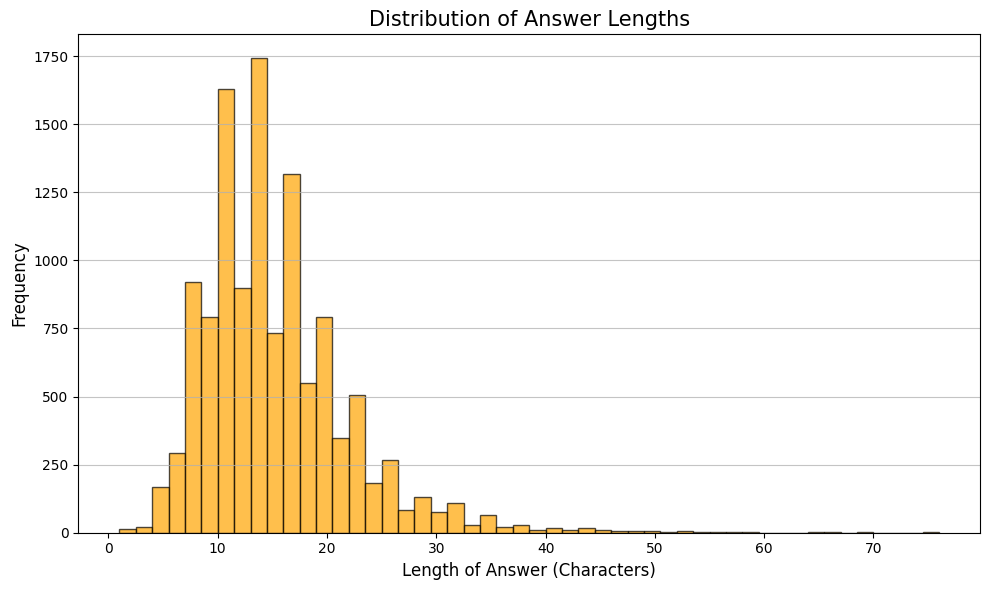

In [164]:
# 답변 길이 분포 히스토그램
plt.figure(figsize=(10, 6))
plt.hist(df['a_len'], bins=50, edgecolor='k', alpha=0.7, color='orange')
plt.title('Distribution of Answer Lengths', fontsize=15)
plt.xlabel('Length of Answer (Characters)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y', alpha=0.75)
plt.tight_layout()
plt.show()

라벨값 분포와 Q,A 길이를 확인했다. 각 50자,30자 내에서 질답이 형성되어있다.

# 데이터 전처리

실습과는 달리 한국어라 다른 전처리를 수행한다.  
먼저 QA를 하나의 리스트로 통합하고 특수문자를 제거만 한다.

In [165]:
# !pip install konlpy

In [166]:
# import pandas as pd
# import matplotlib.pyplot as plt
# from collections import Counter
# from konlpy.tag import Okt
# from wordcloud import WordCloud

# # 1. 데이터 불러오기 및 기본 정보 확인

# print("--- 데이터 기본 정보 ---")
# print(df.info())

# print("\n--- 상위 5개 행 확인 ---")
# print(df.head())

# # 2. 컬럼별 데이터 탐색 및 시각화

# # a) 'label' 컬럼 분포 확인
# print("\n--- 라벨(label) 컬럼 분포 ---")
# label_counts = df['label'].value_counts().sort_index()
# print(label_counts)

# plt.figure(figsize=(8, 6))
# label_counts.plot(kind='bar', color=['skyblue', 'salmon', 'lightgreen'])
# plt.title('Distribution of Labels', fontsize=15)
# plt.xlabel('Label', fontsize=12)
# plt.ylabel('Count', fontsize=12)
# plt.xticks(rotation=0)
# plt.grid(axis='y', alpha=0.75)
# plt.tight_layout()
# plt.show()

# # b) 텍스트 길이 분포 (질문, 답변)
# df['q_len'] = df['Q'].str.len()
# df['a_len'] = df['A'].str.len()

# plt.figure(figsize=(14, 6))

# plt.subplot(1, 2, 1)
# plt.hist(df['q_len'], bins=50, edgecolor='k', alpha=0.7)
# plt.title('Distribution of Question Lengths', fontsize=15)
# plt.xlabel('Length (Characters)', fontsize=12)
# plt.ylabel('Frequency', fontsize=12)
# plt.grid(axis='y', alpha=0.75)

# plt.subplot(1, 2, 2)
# plt.hist(df['a_len'], bins=50, edgecolor='k', alpha=0.7, color='orange')
# plt.title('Distribution of Answer Lengths', fontsize=15)
# plt.xlabel('Length (Characters)', fontsize=12)
# plt.ylabel('Frequency', fontsize=12)
# plt.grid(axis='y', alpha=0.75)

# plt.tight_layout()
# plt.show()

# # 3. 한국어 텍스트 데이터 특징 분석

# # 자주 등장하는 단어 분석 (명사 기준)
# okt = Okt()
# all_words = []
# for text in pd.concat([df['Q'], df['A']]):
#     # 명사만 추출
#     nouns = okt.nouns(str(text))
#     # 한 글자 명사 및 불용어 제거 (선택적)
#     nouns = [n for n in nouns if len(n) > 1 and n not in ['그녀', '남자', '친구', '사랑', '마음', '사람']]
#     all_words.extend(nouns)

# # 단어 빈도 계산
# word_counts = Counter(all_words)
# top_20_words = word_counts.most_common(20)

# print("\n--- 자주 등장하는 단어 TOP 20 ---")
# print(top_20_words)

# # 워드 클라우드 시각화
# wordcloud = WordCloud(
#     font_path='malgun',
#     background_color='white',
#     width=800,
#     height=600
# ).generate_from_frequencies(dict(top_20_words))

# plt.figure(figsize=(10, 8))
# plt.imshow(wordcloud, interpolation='bilinear')
# plt.axis('off')
# plt.title('Word Cloud of Top 20 Words', fontsize=15)
# plt.show()

위 전처리가 크게 도움이 되지 않아 무시함

In [167]:
import re

def remove_special_characters(text):
    if isinstance(text, str):
        # 정규 표현식을 사용하여 특수문자 제거
        # 한글, 영문, 숫자, 공백만 남김
        return re.sub(r'[^가-힣a-zA-Z0-9\s]', '', text)
    else:
        return text

# 'Q'와 'A' 컬럼에 특수문자 제거 함수 적용
print("--- 전처리 전 데이터 (일부) ---")
print(df[['Q', 'A']].head())

df['Q_cleaned'] = df['Q'].apply(remove_special_characters)
df['A_cleaned'] = df['A'].apply(remove_special_characters)

print("\n--- 전처리 후 데이터 (일부) ---")
print(df[['Q_cleaned', 'A_cleaned']].head())


--- 전처리 전 데이터 (일부) ---
                 Q            A
0           12시 땡!   하루가 또 가네요.
1      1지망 학교 떨어졌어    위로해 드립니다.
2     3박4일 놀러가고 싶다  여행은 언제나 좋죠.
3  3박4일 정도 놀러가고 싶다  여행은 언제나 좋죠.
4          PPL 심하네   눈살이 찌푸려지죠.

--- 전처리 후 데이터 (일부) ---
         Q_cleaned   A_cleaned
0            12시 땡   하루가 또 가네요
1      1지망 학교 떨어졌어    위로해 드립니다
2     3박4일 놀러가고 싶다  여행은 언제나 좋죠
3  3박4일 정도 놀러가고 싶다  여행은 언제나 좋죠
4          PPL 심하네   눈살이 찌푸려지죠


의도한대로 전처리가 잘 된거 같다!

# sentencepiece 사용

In [168]:
# !pip install sentencepiece

In [169]:
# DataFrame의 열을 리스트로 변환
q_cleaned_list = df['Q_cleaned'].tolist()
a_cleaned_list = df['A_cleaned'].tolist()

pairs = []
# zip을 이용해 질문과 답변을 짝짓기
for q, a in zip(q_cleaned_list, a_cleaned_list):
    # NaN 값이나 공백이 있다면 건너뛰는 예외 처리 추가
    if pd.isna(q) or pd.isna(a):
        continue
    pairs.append((q.strip(), a.strip()))

print("총 쌍의 개수:", len(pairs))

총 쌍의 개수: 11823


In [170]:
corpus_file = "custom_corpus.txt"
with open(corpus_file, 'w', encoding='utf-8') as f:
    for q, a in pairs:
        f.write(q + "\n")
        f.write(a + "\n")

print(f"'{corpus_file}' 파일이 생성되었습니다.")

'custom_corpus.txt' 파일이 생성되었습니다.


In [171]:
import sentencepiece as spm

spm.SentencePieceTrainer.Train(
    input=corpus_file,
    model_prefix="my_dialog_spm",
    vocab_size=8000,
    character_coverage=1.0,
    model_type="bpe",
    bos_id=1,
    eos_id=2,
    pad_id=0,
    unk_id=3
)

print("SentencePiece 토크나이저 학습이 완료되었습니다.")

SentencePiece 토크나이저 학습이 완료되었습니다.


In [172]:
import sentencepiece as spm

# 1단계: 'sp' 변수를 정의하고 SentencePieceProcessor 객체를 생성합니다.
sp = spm.SentencePieceProcessor()

# 2단계: 'sp' 객체를 이용해 모델을 불러옵니다.
sp.Load("my_dialog_spm.model")

print("모델 로드 완료!")

모델 로드 완료!


In [173]:
# 'my_dialog_spm.model'을 불러옵니다.
sp.Load("my_dialog_spm.model")

# 새로운 문장을 토큰 ID로 변환합니다.
text = "안녕하세요. 저는 AI 챗봇입니다."
token_ids = sp.encode_as_ids(text)

print(f"원본 문장: {text}")
print(f"토큰 ID: {token_ids}")

원본 문장: 안녕하세요. 저는 AI 챗봇입니다.
토큰 ID: [4611, 3, 612, 3193, 3, 6774, 7969, 7407, 402, 3]


In [174]:
# 예제 문장
example_sentence = "트랜스포머 모델에 데이터를 넣으려면 토큰화가 필요합니다."

# 토큰화 (정수 ID로 변환)
encoded_ids = sp.encode_as_ids(example_sentence)
print("\n--- 토크나이저 사용 예시 ---")
print(f"원본 문장: {example_sentence}")
print(f"정수 ID: {encoded_ids}")

# 토큰화 (서브워드 문자열로 변환)
token_strings = sp.encode_as_pieces(example_sentence)
print(f"서브워드: {token_strings}")

# 디코딩 (정수 ID를 다시 문장으로 복원)
decoded_sentence = sp.decode_ids(encoded_ids)
print(f"복원된 문장: {decoded_sentence}")




--- 토크나이저 사용 예시 ---
원본 문장: 트랜스포머 모델에 데이터를 넣으려면 토큰화가 필요합니다.
정수 ID: [1951, 7257, 6863, 7149, 7042, 81, 7895, 6795, 240, 6776, 7023, 6832, 2322, 4293, 6774, 7392, 7205, 4077, 163, 275, 3]
서브워드: ['▁트', '랜', '스', '포', '머', '▁모', '델', '에', '▁데', '이', '터', '를', '▁넣', '으려면', '▁', '토', '큰', '화가', '▁필요', '합니다', '.']
복원된 문장: 트랜스포머 모델에 데이터를 넣으려면 토큰화가 필요합니다 ⁇ 


?? 가 문장 마지막에 붙었다 이는 sp 가 어휘에 없는 단어를 유니코드 대체문자 ' ' 또는 ? 으로 표현하기 때문이다

# 데이터로더 생성

In [175]:
class Dataset(Dataset):
    def __init__(self, pairs, sp, max_length=40):
        super().__init__()
        self.sp = sp
        self.max_length = max_length
        self.data = []

        for q_text, a_text in pairs:
            # 1) 토크나이즈
            q_ids = sp.EncodeAsIds(q_text)
            a_ids = sp.EncodeAsIds(a_text)

            # 2) [CLS]/[SEP] 같은 별도 스페셜 토큰을 쓸 수도 있으나,
            #    여기서는 SentencePiece 기본 <s>, </s> 등 혹은 사용자 정의 토큰 활용 가능
            #    간단히 <s>=sp.bos_id(), </s>=sp.eos_id()로 가정해본다면:
            #    sp.SetEncodeExtraOptions("bos:eos") 등으로 설정하는 방법도 있음.
            # 여기서는 수동으로 bos/eos id를 붙인다고 가정
            bos_id = sp.bos_id() if sp.bos_id() >= 0 else 1  # 혹은 임의값
            eos_id = sp.eos_id() if sp.eos_id() >= 0 else 2

            q_tokens = [bos_id] + q_ids + [eos_id]
            a_tokens = [bos_id] + a_ids + [eos_id]

            # 3) 길이 제한
            if len(q_tokens) > max_length or len(a_tokens) > max_length:
                continue

            # 4) 고정 길이 패딩
            q_tokens += [0]*(max_length - len(q_tokens))  # 0 -> <pad> 가정
            a_tokens += [0]*(max_length - len(a_tokens))

            # 5) 디코더 입력(dec_input): a_tokens[:-1], 타겟(outputs): a_tokens[1:]
            #    (teacher forcing용)
            dec_input = a_tokens[:-1]
            target = a_tokens[1:]

            self.data.append({
                "enc_input": q_tokens,
                "dec_input": dec_input,
                "target": target
            })

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        enc_input = torch.tensor(sample["enc_input"], dtype=torch.long)
        dec_input = torch.tensor(sample["dec_input"], dtype=torch.long)
        target = torch.tensor(sample["target"], dtype=torch.long)
        return enc_input, dec_input, target

In [176]:
dataset = Dataset(pairs, sp, max_length=40)

In [177]:
for encoder_input, decoder_input, decoder_label  in dataset:
    print("텐서 크기 :",encoder_input.size())
    print(encoder_input)
    print(sp.decode(encoder_input.tolist()))
    print(decoder_input)
    print(sp.decode(decoder_input.tolist()))
    print(decoder_label)
    print(sp.decode(decoder_label.tolist()))
    break

텐서 크기 : torch.Size([40])
tensor([   1, 5551, 6814, 3197,    2,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0])
12시 땡
tensor([   1, 4478,  211, 5920,    2,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0])
하루가 또 가네요
tensor([4478,  211, 5920,    2,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0])
하루가 또 가네요


In [178]:
dataloader = DataLoader(dataset,batch_size=32,shuffle=True)

In [179]:
for encoder_input, decoder_input, decoder_label in dataloader:
    print(encoder_input.size())
    print(decoder_input.size())
    print(decoder_label.size())
    break

torch.Size([32, 40])
torch.Size([32, 39])
torch.Size([32, 39])


# 모델 구성

In [180]:
class PositionalEncoding(nn.Module):
    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.d_model = d_model
        self.position = position

        self.pos_encoding = self._build_pos_encoding(position, d_model)

    def _get_angles(self, position, i, d_model):
        return 1.0 / (10000.0 ** ((2.0 * (i // 2)) / d_model)) * position

    def _build_pos_encoding(self, position, d_model):
        pos = torch.arange(position, dtype=torch.float32).unsqueeze(1)
        i = torch.arange(d_model, dtype=torch.float32).unsqueeze(0)

        angle_rads = self._get_angles(pos, i, d_model)
        sines = torch.sin(angle_rads[:, 0::2])
        cosines = torch.cos(angle_rads[:, 1::2])

        pos_encoding = torch.zeros(position, d_model)
        pos_encoding[:, 0::2] = sines
        pos_encoding[:, 1::2] = cosines

        pos_encoding = pos_encoding.unsqueeze(0)  # shape: [1, position, d_model]
        return pos_encoding

    def forward(self, x):
        return x + self.pos_encoding[:, :x.size(1), :].to(x.device)

In [181]:
def scaled_dot_product_attention(query, key, value, mask=None):

    # 1) Q와 K의 내적을 통해 score(유사도) 계산
    # key.transpose(-1, -2): (batch_size, heads, depth, seq_len)
    # matmul 결과 shape: (batch_size, heads, seq_len, seq_len)
    matmul_qk = torch.matmul(query, key.transpose(-1, -2))

    # 2) depth에 따라 정규화
    depth = key.size(-1)  # depth = d_model / heads
    logits = matmul_qk / math.sqrt(depth)

    # 3) 마스크가 주어졌다면 -1e9(아주 작은 값)를 더해 소프트맥스에서 제외시키도록 함
    if mask is not None:
        # 텐서플로우: logits += (mask * -1e9)
        # 파이토치 동일 적용
        logits = logits + (mask * -1e9)

    # 4) 소프트맥스 계산해 attention weights 생성
    attention_weights = F.softmax(logits, dim=-1)

    # 5) attention weights와 value의 내적
    output = torch.matmul(attention_weights, value)

    return output, attention_weights

In [182]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        # d_model은 num_heads로 나누어떨어져야 함
        assert d_model % num_heads == 0

        self.depth = d_model // num_heads

        # 파이토치에서 Dense는 nn.Linear로 대응
        self.query_dense = nn.Linear(d_model, d_model)
        self.key_dense = nn.Linear(d_model, d_model)
        self.value_dense = nn.Linear(d_model, d_model)

        self.out_dense = nn.Linear(d_model, d_model)

    def split_heads(self, x, batch_size):
        """
        x: (batch_size, seq_len, d_model)
        => (batch_size, num_heads, seq_len, depth) 형태로 변환
        """
        x = x.view(batch_size, -1, self.num_heads, self.depth)
        x = x.permute(0, 2, 1, 3)  # (batch_size, num_heads, seq_len, depth)
        return x

    def forward(self, query, key, value, mask=None):
        """
        query, key, value: (batch_size, seq_len, d_model)
        mask: (batch_size, 1, seq_len, seq_len) 등으로 broadcast 가능하도록 구성
        """
        batch_size = query.size(0)

        # Q, K, V에 각각 Linear 적용
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        # Head 분할
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        # 스케일드 닷 프로덕트 어텐션
        scaled_attention, _ = scaled_dot_product_attention(query, key, value, mask)

        # (batch_size, num_heads, seq_len, depth) -> (batch_size, seq_len, num_heads, depth)
        scaled_attention = scaled_attention.permute(0, 2, 1, 3).contiguous()

        # 다시 (batch_size, seq_len, d_model)로 합치기
        concat_attention = scaled_attention.view(batch_size, -1, self.d_model)

        # 최종 Dense
        output = self.out_dense(concat_attention)
        return output


In [183]:
def create_padding_mask(x):
    # x == 0 위치를 찾아 float형 1로 변환
    mask = (x == 0).float()
    # (batch_size, seq_len) -> (batch_size, 1, 1, seq_len)
    mask = mask.unsqueeze(1).unsqueeze(2)
    return mask

In [184]:
def create_look_ahead_mask(x):
    seq_len = x.size(1)

    # (seq_len, seq_len) 크기의 하삼각 행렬(tril) 생성 후 1에서 빼서
    # 상삼각이 1, 하삼각(자기 자신 포함)이 0이 되도록 설정
    # => 미래 토큰(자신 인덱스보다 큰 위치) 마스킹
    look_ahead_mask = 1 - torch.tril(torch.ones((seq_len, seq_len)))

    # 패딩 마스크 생성 (shape: (batch_size, 1, 1, seq_len))
    padding_mask = create_padding_mask(x)

    # look_ahead_mask: (seq_len, seq_len) -> (1, seq_len, seq_len)
    look_ahead_mask = look_ahead_mask.unsqueeze(0)
    # -> (1, seq_len, seq_len) -> (1, 1, seq_len, seq_len)
    look_ahead_mask = look_ahead_mask.unsqueeze(1)
    look_ahead_mask = look_ahead_mask.to(x.device)

    # look-ahead 마스크와 패딩 마스크를 합성 (둘 중 하나라도 1이면 마스킹)
    # 최종 shape은 브로드캐스팅으로 (batch_size, 1, seq_len, seq_len)
    combined_mask = torch.max(look_ahead_mask, padding_mask)
    return combined_mask

In [185]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, ff_dim, dropout=0.1):
        super(EncoderLayer, self).__init__()
        self.mha = MultiHeadAttention(d_model, num_heads)  # 이전에 구현한 MHA
        self.dropout1 = nn.Dropout(dropout)
        self.norm1 = nn.LayerNorm(d_model, eps=1e-6)

        # 피드포워드 부분 (Dense -> ReLU -> Dense)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, ff_dim),
            nn.ReLU(),
            nn.Linear(ff_dim, d_model)
        )
        self.dropout2 = nn.Dropout(dropout)
        self.norm2 = nn.LayerNorm(d_model, eps=1e-6)

    def forward(self, x, mask=None):
        # (1) 멀티 헤드 어텐션 (셀프 어텐션)
        attn_output = self.mha(x, x, x, mask)  # (batch_size, seq_len, d_model)
        attn_output = self.dropout1(attn_output)
        out1 = self.norm1(x + attn_output)     # 잔차 연결 + LayerNorm

        # (2) 피드포워드 신경망
        ffn_output = self.ffn(out1)            # (batch_size, seq_len, d_model)
        ffn_output = self.dropout2(ffn_output)
        out2 = self.norm2(out1 + ffn_output)   # 잔차 연결 + LayerNorm

        return out2


In [186]:
class Encoder(nn.Module):
    def __init__(self,
                 vocab_size,
                 num_layers,
                 ff_dim,
                 d_model,
                 num_heads,
                 dropout=0.1):
        super(Encoder, self).__init__()
        self.d_model = d_model

        # (1) 임베딩 레이어
        self.embedding = nn.Embedding(vocab_size, d_model)

        # (2) 포지셔널 인코딩
        self.pos_encoding = PositionalEncoding(position=vocab_size, d_model=d_model)

        self.dropout = nn.Dropout(dropout)

        # (3) EncoderLayer 쌓기
        self.enc_layers = nn.ModuleList([
            EncoderLayer(d_model, num_heads, ff_dim, dropout)
            for _ in range(num_layers)
        ])

    def forward(self, x, mask=None):
        # (1) 임베딩 & sqrt(d_model)로 스케일링
        x = self.embedding(x) * math.sqrt(self.d_model)

        # (2) 포지셔널 인코딩 적용 + 드롭아웃
        x = self.pos_encoding(x)  # shape: (batch_size, seq_len, d_model)
        x = self.dropout(x)

        # (3) num_layers만큼 쌓아올린 EncoderLayer 통과
        for layer in self.enc_layers:
            x = layer(x, mask)

        return x

In [187]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, ff_dim, dropout=0.1):
        super(DecoderLayer, self).__init__()

        # 첫 번째 서브 레이어 (디코더 내부 셀프 어텐션)
        self.self_mha = MultiHeadAttention(d_model, num_heads)
        self.norm1 = nn.LayerNorm(d_model, eps=1e-6)

        # 두 번째 서브 레이어 (인코더-디코더 어텐션)
        self.encdec_mha = MultiHeadAttention(d_model, num_heads)
        self.norm2 = nn.LayerNorm(d_model, eps=1e-6)

        # 세 번째 서브 레이어 (피드포워드 네트워크)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, ff_dim),  # Dense(units=ff_dim)
            nn.ReLU(),                   # activation='relu'
            nn.Linear(ff_dim, d_model)   # Dense(units=d_model)
        )
        self.norm3 = nn.LayerNorm(d_model, eps=1e-6)

        # 드롭아웃
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.dropout3 = nn.Dropout(dropout)

    def forward(self, x, enc_outputs, look_ahead_mask=None, padding_mask=None):
        # 1) 셀프 어텐션 (디코더 내부)
        self_attn_out = self.self_mha(x, x, x, mask=look_ahead_mask)
        self_attn_out = self.dropout1(self_attn_out)
        out1 = self.norm1(x + self_attn_out)  # 잔차 연결 + LayerNorm

        # 2) 인코더-디코더 어텐션
        encdec_attn_out = self.encdec_mha(out1, enc_outputs, enc_outputs, mask=padding_mask)
        encdec_attn_out = self.dropout2(encdec_attn_out)
        out2 = self.norm2(out1 + encdec_attn_out)  # 잔차 연결 + LayerNorm

        # 3) 피드포워드 (Dense -> ReLU -> Dense)
        ffn_out = self.ffn(out2)
        ffn_out = self.dropout3(ffn_out)
        out3 = self.norm3(out2 + ffn_out)  # 잔차 연결 + LayerNorm

        return out3

In [188]:
class Decoder(nn.Module):
    def __init__(self,
                 vocab_size,
                 num_layers,
                 ff_dim,
                 d_model,
                 num_heads,
                 dropout=0.1):
        super(Decoder, self).__init__()
        self.d_model = d_model

        # (1) 임베딩 레이어
        self.embedding = nn.Embedding(vocab_size, d_model)

        # (2) 포지셔널 인코딩
        # 실제 학습 시에는 최대 시퀀스 길이에 맞추어 쓰기도 함
        self.pos_encoding = PositionalEncoding(position=vocab_size, d_model=d_model)

        self.dropout = nn.Dropout(dropout)

        # (3) DecoderLayer 쌓기
        self.dec_layers = nn.ModuleList([
            DecoderLayer(d_model, num_heads, ff_dim, dropout)
            for _ in range(num_layers)
        ])

    def forward(self, x, enc_outputs, look_ahead_mask=None, padding_mask=None):
        # (1) 임베딩 + sqrt(d_model)로 스케일링
        x = self.embedding(x) * math.sqrt(self.d_model)

        # (2) 포지셔널 인코딩 + 드롭아웃
        x = self.pos_encoding(x)    # (batch_size, tgt_seq_len, d_model)
        x = self.dropout(x)

        # (3) num_layers만큼 쌓인 DecoderLayer 통과
        for layer in self.dec_layers:
            x = layer(x, enc_outputs, look_ahead_mask, padding_mask)

        return x

In [189]:
class Transformer(nn.Module):
    def __init__(self,
                 vocab_size,
                 num_layers,      # 인코더/디코더 층 수
                 units,           # feed-forward 네트워크의 중간 차원(ff_dim)
                 d_model,         # 임베딩 및 내부 표현 차원
                 num_heads,       # 멀티헤드 어텐션의 헤드 수
                 dropout=0.1):
        super(Transformer, self).__init__()

        # 인코더
        self.encoder = Encoder(
            vocab_size=vocab_size,
            num_layers=num_layers,
            ff_dim=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout
        )

        # 디코더
        self.decoder = Decoder(
            vocab_size=vocab_size,
            num_layers=num_layers,
            ff_dim=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout
        )

        # 최종 출력층: (d_model) -> (vocab_size)
        self.final_linear = nn.Linear(d_model, vocab_size)

        # 참고: 텐서플로우 코드의 `name="transformer"`는 파이토치에선 보통 사용 안 함

    def forward(self, inputs, dec_inputs):
        # 1) 인코더 패딩 마스크 생성
        enc_padding_mask = create_padding_mask(inputs)     # shape (batch_size, 1, 1, src_seq_len)

        # 2) 디코더 look-ahead + 패딩 마스크
        look_ahead_mask = create_look_ahead_mask(dec_inputs)  # shape (batch_size, 1, tgt_seq_len, tgt_seq_len)

        # 3) 디코더에서 인코더 출력 쪽을 마스킹할 때 쓸 패딩 마스크
        dec_padding_mask = create_padding_mask(inputs)        # shape (batch_size, 1, 1, src_seq_len)

        # 4) 인코더 수행
        enc_outputs = self.encoder(
            x=inputs,
            mask=enc_padding_mask
        )  # shape: (batch_size, src_seq_len, d_model)

        # 5) 디코더 수행
        dec_outputs = self.decoder(
            x=dec_inputs,           # (batch_size, tgt_seq_len)
            enc_outputs=enc_outputs,# (batch_size, src_seq_len, d_model)
            look_ahead_mask=look_ahead_mask,
            padding_mask=dec_padding_mask
        )  # shape: (batch_size, tgt_seq_len, d_model)

        # 6) 최종 Dense (vocab_size)
        logits = self.final_linear(dec_outputs)  # (batch_size, tgt_seq_len, vocab_size)
        return logits

In [190]:
# 예: 하이퍼파라미터 설정
NUM_LAYERS = 2     # 인코더/디코더 층 수
D_MODEL = 256      # 임베딩 및 내부 표현 차원
NUM_HEADS = 8      # 멀티헤드 어텐션에서의 헤드 수
UNITS = 512        # 피드포워드 신경망의 은닉 차원
DROPOUT = 0.1      # 드롭아웃 비율
VOCAB_SIZE = 8000 # 단어 집합 크기(예시)

# 모델 생성
model = Transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT
)

print(model)

Transformer(
  (encoder): Encoder(
    (embedding): Embedding(8000, 256)
    (pos_encoding): PositionalEncoding()
    (dropout): Dropout(p=0.1, inplace=False)
    (enc_layers): ModuleList(
      (0-1): 2 x EncoderLayer(
        (mha): MultiHeadAttention(
          (query_dense): Linear(in_features=256, out_features=256, bias=True)
          (key_dense): Linear(in_features=256, out_features=256, bias=True)
          (value_dense): Linear(in_features=256, out_features=256, bias=True)
          (out_dense): Linear(in_features=256, out_features=256, bias=True)
        )
        (dropout1): Dropout(p=0.1, inplace=False)
        (norm1): LayerNorm((256,), eps=1e-06, elementwise_affine=True)
        (ffn): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): ReLU()
          (2): Linear(in_features=512, out_features=256, bias=True)
        )
        (dropout2): Dropout(p=0.1, inplace=False)
        (norm2): LayerNorm((256,), eps=1e-06, elementwise_aff

In [191]:
loss_function = nn.CrossEntropyLoss(ignore_index=sp.pad_id())

In [192]:
def get_lr_lambda(d_model, warmup_steps=4000):
    d_model = float(d_model)
    def lr_lambda(step):
        # step은 0부터 시작하므로 +1로 보정
        step = step + 1
        return (d_model ** -0.5) * min(step ** -0.5, step * (warmup_steps ** -1.5))
    return lr_lambda

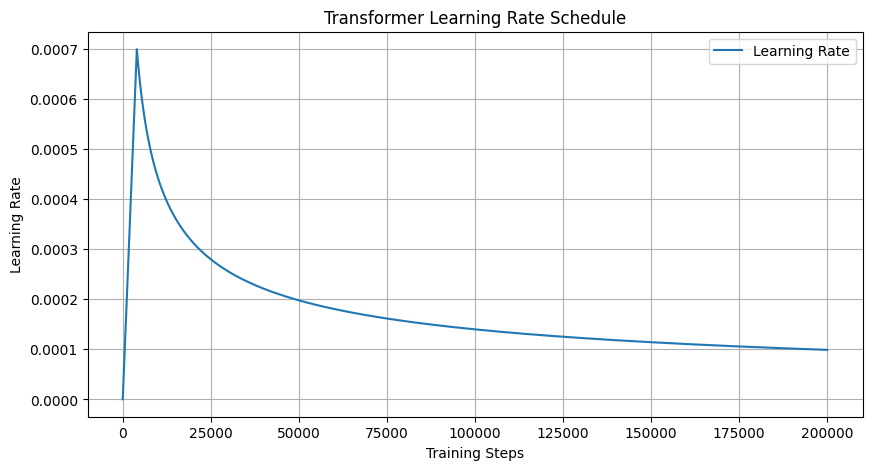

In [193]:
# 하이퍼파라미터 설정
d_model = 512
warmup_steps = 4000
total_steps = 200000  # 총 학습 스텝

# 학습률 스케줄 시각화
steps = np.arange(1, total_steps + 1)
learning_rates = [get_lr_lambda(d_model, warmup_steps)(step) for step in steps]

# 그래프 출력
plt.figure(figsize=(10, 5))
plt.plot(steps, learning_rates, label="Learning Rate")
plt.xlabel("Training Steps")
plt.ylabel("Learning Rate")
plt.title("Transformer Learning Rate Schedule")
plt.legend()
plt.grid(True)
plt.show()


In [194]:
# Optimizer 정의
optimizer = optim.Adam(model.parameters(), betas=(0.9, 0.98), eps=1e-9)

# Scheduler 정의
scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda=get_lr_lambda(D_MODEL, warmup_steps=4000))

def accuracy_function(y_pred, y_true, pad_id=0):
    """
    y_pred: (batch_size, seq_len, vocab_size)
    y_true: (batch_size, seq_len)
    """
    preds = y_pred.argmax(dim=-1)  # (batch_size, seq_len)
    mask = (y_true != pad_id)
    correct = (preds == y_true) & mask
    acc = correct.float().sum() / mask.float().sum()
    return acc

In [195]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model = model.to(device)

cuda


In [196]:
def train_step(model, batch, optimizer, loss_function, device):
    model.train()
    enc_input, dec_input, target = [x.to(device) for x in batch]

    optimizer.zero_grad()

    # 모델 포워드 패스
    logits = model(enc_input, dec_input)  # (batch_size, seq_len, vocab_size)

    # Loss 계산 (패딩 토큰 무시)
    loss = loss_function(logits.permute(0, 2, 1), target)  # (batch_size, vocab_size, seq_len) 필요

    # Backpropagation
    loss.backward()
    optimizer.step()

    return loss.item(), accuracy_function(logits, target, pad_id=sp.pad_id())

In [197]:
def train(model, dataloader, optimizer, loss_function, scheduler, num_epochs, device):
    model.to(device)

    for epoch in range(num_epochs):
        total_loss, total_acc = 0, 0
        for step, batch in enumerate(dataloader):
            loss, acc = train_step(model, batch, optimizer, loss_function, device)
            total_loss += loss
            total_acc += acc

            # 일정 스텝마다 로그 출력
            if step % 100 == 0:
                print(f"[Epoch {epoch+1}, Step {step}] Loss: {loss:.4f}, Acc: {acc:.4f}")

            # 학습률 스케줄러 업데이트
            scheduler.step()

        avg_loss = total_loss / len(dataloader)
        avg_acc = total_acc / len(dataloader)
        print(f"Epoch {epoch+1} Completed - Avg Loss: {avg_loss:.4f}, Avg Acc: {avg_acc:.4f}")

In [198]:
%%time

train(
    model=model,
    dataloader=dataloader,
    optimizer=optimizer,
    loss_function=loss_function,
    scheduler=scheduler,
    num_epochs=25,  # 원하는 에폭 수
    device=device
)

[Epoch 1, Step 0] Loss: 9.2506, Acc: 0.0000
[Epoch 1, Step 100] Loss: 9.1531, Acc: 0.0000
[Epoch 1, Step 200] Loss: 9.1607, Acc: 0.0000
[Epoch 1, Step 300] Loss: 9.1086, Acc: 0.0000
Epoch 1 Completed - Avg Loss: 9.1613, Avg Acc: 0.0001
[Epoch 2, Step 0] Loss: 9.1096, Acc: 0.0000
[Epoch 2, Step 100] Loss: 9.1855, Acc: 0.0000
[Epoch 2, Step 200] Loss: 9.1894, Acc: 0.0000
[Epoch 2, Step 300] Loss: 9.0672, Acc: 0.0000
Epoch 2 Completed - Avg Loss: 9.1326, Avg Acc: 0.0002
[Epoch 3, Step 0] Loss: 9.0572, Acc: 0.0000
[Epoch 3, Step 100] Loss: 9.0428, Acc: 0.0000
[Epoch 3, Step 200] Loss: 9.0368, Acc: 0.0000
[Epoch 3, Step 300] Loss: 9.1417, Acc: 0.0000
Epoch 3 Completed - Avg Loss: 9.0754, Avg Acc: 0.0006
[Epoch 4, Step 0] Loss: 9.0644, Acc: 0.0000
[Epoch 4, Step 100] Loss: 9.0458, Acc: 0.0000
[Epoch 4, Step 200] Loss: 9.0219, Acc: 0.0056
[Epoch 4, Step 300] Loss: 8.9789, Acc: 0.0149
Epoch 4 Completed - Avg Loss: 8.9899, Avg Acc: 0.0046
[Epoch 5, Step 0] Loss: 8.8364, Acc: 0.0056
[Epoch 5, St

In [206]:
torch.save(model, 'model.pth')



# 모델 평가

In [209]:
import torch
import sentencepiece as spm

# 1. 모델과 토크나이저 불러오기
# 학습된 SentencePiece 토크나이저 모델 로드
sp = spm.SentencePieceProcessor()
sp.Load("my_dialog_spm.model") # SentencePiece 모델 파일 경로

# 학습된 PyTorch 모델 불러오기
# torch.load는 모델 객체를 직접 로드합니다.
model = torch.load('model.pth') # PyTorch 모델 저장 경로

# 2. 모델을 평가 모드로 전환 및 디바이스 설정

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

model.eval()

# 3. 무한 루프를 이용한 대화 시작
print("챗봇과 대화를 시작합니다! (종료하려면 '종료'를 입력하세요)")

# 최대 응답 길이는 학습 시 설정한 max_length와 일치시키는 것이 좋습니다.
MAX_RESPONSE_LENGTH = 40 # 데이터셋 생성 시 사용한 max_length와 동일하게 설정

while True:
    user_input = input("나: ")
    if user_input.strip().lower() == '종료':
        print("대화를 종료합니다.")
        break

    # 입력 문장 전처리 (학습 시와 동일하게)
    cleaned_input = remove_special_characters(user_input)

    # 입력 문장을 토큰 ID로 변환
    # SentencePiece의 encode_as_ids 사용
    input_ids = sp.encode_as_ids(cleaned_input)

    # 데이터셋 클래스에서 사용한 [BOS] 및 [EOS] 토큰 추가
    bos_id = sp.bos_id() if sp.bos_id() >= 0 else 1
    eos_id = sp.eos_id() if sp.eos_id() >= 0 else 2
    pad_id = sp.pad_id() if sp.pad_id() >= 0 else 0

    input_tokens = [bos_id] + input_ids + [eos_id]

    # 패딩 (학습 시 사용한 max_length에 맞춰 패딩)
    # 인코더 입력은 max_length, 디코더 입력/타겟은 max_length-1 이었음을 고려
    # 추론 시에는 인코더 입력만 필요하며, 디코더 입력은 <sos> 부터 시작해서 생성
    # 여기서는 간단하게 인코더 입력을 max_length에 맞춰 패딩합니다.
    # 실제 추론 함수에서는 디코더 입력 생성 로직이 필요합니다.
    # 이 예시에서는 간단한 시퀀스 생성 로직을 구현합니다.

    # 인코더 입력 텐서 준비
    enc_input = torch.tensor([input_tokens], dtype=torch.long, device=device)
    # 패딩 처리 (MAX_RESPONSE_LENGTH에 맞춰도 무방하며, 모델 학습 길이에 맞춰야 함)
    enc_input = torch.nn.functional.pad(enc_input, (0, MAX_RESPONSE_LENGTH - enc_input.size(1)), "constant", pad_id)


    # 모델 추론 (Seq2Seq 추론 로직 필요)
    # Transformer 모델의 생성은 조금 더 복잡하며, 토큰 하나씩 생성하며
    # 디코더의 입력으로 이전 스텝의 생성 결과를 사용하는 방식을 따릅니다.
    # 여기서는 간소화된 추론 예시를 보여줍니다.

    # 디코더 입력 초기화: [BOS] 토큰으로 시작
    dec_input = torch.tensor([[bos_id]], dtype=torch.long, device=device)

    generated_tokens = []
    with torch.no_grad():
        # MAX_RESPONSE_LENGTH까지 토큰 생성 시도
        for _ in range(MAX_RESPONSE_LENGTH -1): # -1은 BOS 토큰 제외
            # 인코더 출력 계산 (입력 문장은 고정)
            enc_outputs = model.encoder(enc_input, create_padding_mask(enc_input))

            # 디코더의 look-ahead 마스크 및 패딩 마스크 생성
            look_ahead_mask = create_look_ahead_mask(dec_input)
            dec_padding_mask = create_padding_mask(enc_input) # 인코더 입력에 대한 패딩 마스크

            # 디코더 수행
            dec_outputs = model.decoder(
                x=dec_input,
                enc_outputs=enc_outputs,
                look_ahead_mask=look_ahead_mask,
                padding_mask=dec_padding_mask
            )

            # 최종 출력층 통과하여 다음 토큰 예측 로짓 얻기
            logits = model.final_linear(dec_outputs[:, -1:, :]) # 마지막 토큰에 대한 로짓만 사용

            # 다음 토큰 ID 선택 (가장 높은 확률의 토큰 선택, Greedy Search)
            next_token_id = torch.argmax(logits, dim=-1).squeeze().item()

            # [EOS] 토큰이 생성되면 생성 중단
            if next_token_id == eos_id or next_token_id == pad_id:
                break

            # 생성된 토큰 추가
            generated_tokens.append(next_token_id)

            # 다음 스텝의 디코더 입력으로 현재 생성된 토큰 추가
            dec_input = torch.cat([dec_input, torch.tensor([[next_token_id]], dtype=torch.long, device=device)], dim=1)

    # 생성된 토큰 ID들을 문장으로 디코딩
    response = sp.decode_ids(generated_tokens)

    print(f"챗봇: {response}")

AttributeError: 'collections.OrderedDict' object has no attribute 'to'